#INTRODUCTION

This notebook is a part of our final project for class CS221.O11 of University of information and technology

Our group:
- Lê Tuấn Vũ (21521679)
- Trần Nhật Phong (21521276)
- Nguyễn Nhật Minh (21521135)

This notebook aim to embedding data and train-validate the classifier

Further this notebook also demonstrate our skill on analysing and processing data.


#Install and Import Module

In [ ]:
!pip install transformers
!pip install tokenizers
!pip install autocorrect
!pip install emot --upgrade
!pip install emoji
!pip install underthesea
!pip install py_vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=350e7acbe83ddadca06e2407069825e595427be3cdc82fb3d40222122870d19f
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 492.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 47.1 MB/s eta 0:00:00


In [ ]:
import os
import subprocess
import nltk
import pandas as pd
import re
import string
import emoji
import emot
import py_vncorenlp
from transformers import AutoModel, AutoTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from autocorrect import Speller

#Load & Define Model

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
p = pipeline("feature-extraction", model=phobert, tokenizer=tokenizer, aggregation_strategy="simple", device = device )

In [ ]:
sentence = 'Chúng tôi không là những nghiên cứu viên .'
print([tokenizer.tokenize(sentence)])
input_ids = torch.tensor([tokenizer.encode(sentence)]).to(device)

with torch.no_grad():
    features = phobert(input_ids)  # Models outputs are now tuples

[['Chúng', 'tôi', 'không', 'là', 'những', 'nghiên', 'cứu', 'viên', '.']]


#Preprocessing data

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
#@title Replace the word that not exist in Vietnames dictionary
r_dict={}
with open('/content/mydrive/MyDrive/NLP Final Project/not_in_vocab.txt', 'r') as f:
  for line in f:
    line_compo = line.rstrip().split(':')
    r_dict[line_compo[0]]= line_compo[1]

In [ ]:
#@title Remove stopword
stopwords = []

with open("/content/mydrive/MyDrive/NLP Final Project/vietnamese.txt", "r") as f:
    stopwords = f.read().splitlines()
stopwords = [word.replace(' ', '_') for word in stopwords]

In [ ]:
# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
py_vncorenlp.download_model(save_dir='/content/')

# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/')

In [ ]:
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct,' '))

In [ ]:
def preprocess(s, stopswords = stopwords, rdrsegmenter = rdrsegmenter, r_dict = r_dict ):
  processed_sent = s.lower()
  processed_sent = emoji.replace_emoji(processed_sent, ' ')
  processed_sent = processed_sent.translate(transtab)
  processed_sent = re.sub('\d+', ' ',processed_sent)
  processed_sent = processed_sent.strip()
  processed_sent = rdrsegmenter.word_segment(processed_sent)[0]
  processed_sent = ' '.join([r_dict.get(i, i) for i in processed_sent.split()])
  processed_sent = ' '.join([word for word in processed_sent.split() if word not in (stopwords)])
  return processed_sent

In [ ]:
import pandas as pd

df_train = pd.read_csv('/content/mydrive/MyDrive/NLP Final Project/data_train.csv')
df_test = pd.read_csv('/content/mydrive/MyDrive/NLP Final Project/data_test.csv')

In [ ]:
#@title Drop any nan in dataset
df_train = df_train[df_train['fully_process'].notna()]
df_test = df_test[df_test['fully_process'].notna()]
df_train.isna().sum()

Unnamed: 0       0
label            0
star             0
fully_process    0
dtype: int64

In [ ]:
#@title Pass data to X, y

def create_embed_vec(X):
  embedding = []
  for sentence in X:
    embedding.append(p(sentence))
  return embedding


X_train=create_embed_vec(df_train['fully_process'].tolist())
X_test=create_embed_vec(df_test['fully_process'].tolist())

convert = {
    'POS':0,
    "NEU":1,
    "NEG":2
}

y_train=[ convert[ele] for ele in df_train['label'].tolist()]
y_test= [ convert[ele] for ele in df_test['label'].tolist()]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
X_train = [x[0][0] for x in X_train]
X_test = [x[0][0] for x in X_test]

#Train classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


clf_lr = make_pipeline(StandardScaler(), LogisticRegression())
clf_mlp = make_pipeline(StandardScaler(), MLPClassifier())

clf_lr.fit(X_train, y_train)
clf_mlp.fit(X_train, y_train)

In [ ]:
clf_svm2 =  make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
clf_svm3= make_pipeline(StandardScaler(), SVC(kernel = 'sigmoid'))
clf_svm2.fit(X_train, y_train)
clf_svm3.fit(X_train, y_train)

#Classifier results

In [ ]:
from sklearn.metrics import accuracy_score

#pred_svm1 = clf_svm1.predict(X_test)
pred_svm2 = clf_svm2.predict(X_test)
pred_svm3 = clf_svm3.predict(X_test)
pred_lr = clf_lr.predict(X_test)
pred_mlp = clf_mlp.predict(X_test)

#print(f'Accuracy score of SVM: {accuracy_score(y_test, pred_svm1)}')
print(f'Accuracy score of SVM: {accuracy_score(y_test, pred_svm2)}')
print(f'Accuracy score of SVM: {accuracy_score(y_test, pred_svm3)}')
print(f'Accuracy score of Logistic Regression: {accuracy_score(y_test, pred_lr)}')
print(f'Accuracy score of Multi-layer Perceptron: {accuracy_score(y_test, pred_mlp)}')

Accuracy score of SVM: 0.7803477428617004
Accuracy score of SVM: 0.7257935874940182
Accuracy score of Logistic Regression: 0.76583187111182
Accuracy score of Multi-layer Perceptron: 0.7363215823895358


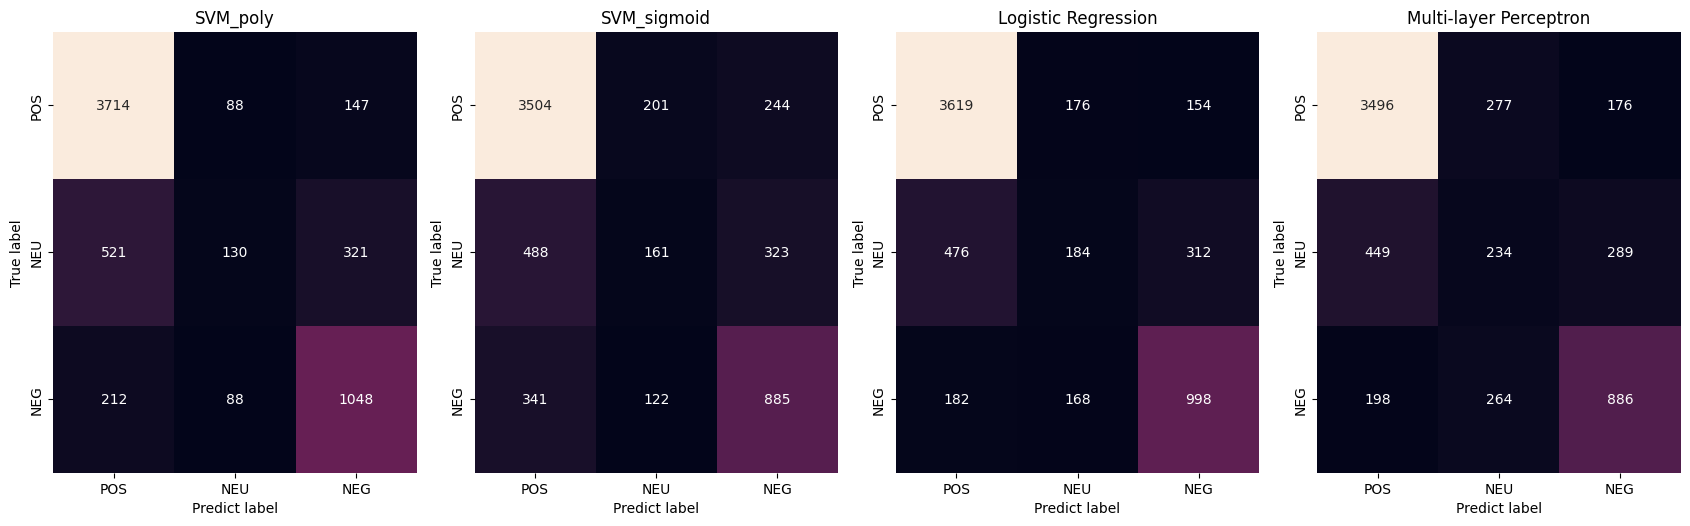

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred = [pred_svm2, pred_svm3, pred_lr, pred_mlp]
model_names = ["SVM_poly","SVM_sigmoid", "Logistic Regression", "Multi-layer Perceptron"]


fig, axes = plt.subplots(ncols=4, figsize=(17,5))
plt.tight_layout()
for i in range(4):
  conf = confusion_matrix(y_test, pred[i])
  sns.heatmap(conf, annot=True, xticklabels=["POS", "NEU", "NEG"], yticklabels=["POS", "NEU", "NEG"], fmt='g', cbar=False, ax=axes[i])
  axes[i].set(title = model_names[i],xlabel="Predict label", ylabel='True label')



Text(0.1, 0.5, 'True label')

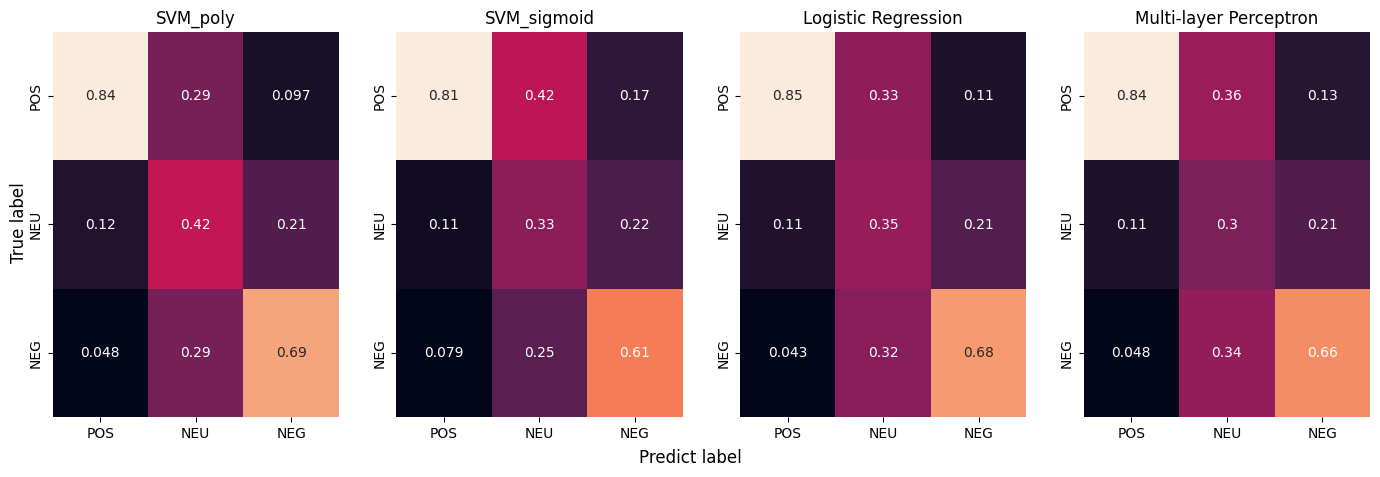

In [ ]:
#percentage confusion matrix
fig, axes = plt.subplots(ncols=4, figsize=(17,5))

for i in range(4):
  conf = confusion_matrix(y_test, pred[i])
  #recall confusion matrix
  conf_n = (conf.T/conf.T.sum(axis=0)).T

  #precision Confusion matrix
  conf_n = (conf/conf.sum(axis=0))

  axes[i].set(title = model_names[i])

  sns.heatmap(conf_n, annot=True, xticklabels=["POS", "NEU", "NEG"], yticklabels=["POS", "NEU", "NEG"], cbar=False, ax=axes[i])
fig.supxlabel("Predict label")
fig.supylabel("True label", x=0.1)

In [ ]:
#@title Single Prediction
inv_dic = {0:'POS', 1:'NEU', 2:'NEG'}

demo_sentence = "vải hơi thô cứng Thời gian giao hàng nhanh."
vec = p(demo_sentence)
preprocessing_sentence = preprocess(demo_sentence)
result = clf_svm2.predict([vec[0][0]])
print(f'Ngữ liệu đầu vào: {demo_sentence}')
print(f'Ngữ liệu sau khi được preprocessing: {preprocessing_sentence}')

print()
print(f'Predict label: {inv_dic[result[0]]}')
print(f'True label: POS')
print()